In [ ]:
################################################################################
# BELOW IS CODE ADAPTED FROM:
# 
# Escape Velocity Labs, 28/08/22, 'Advanced Reinforcement Learning in Python: from DQN to SAC', 
# Accessed at https://www.udemy.com/course/advanced-reinforcement/ 
#
# Note: There is a section towards the bottom which is purely self coded (all except for the Training function used), this has been labelled clearly.
################################################################################

In [ ]:
### Install dependencies
### Note: you need to restart the runtime after you run this cell

!apt-get install -y xvfb # Used to display videos and GUI's in this notebook

!pip install \
    gym==0.21 \
    gym[box2d] \
    pytorch-lightning==1.6.0 \
    pyvirtualdisplay

# gym -> Environment 
# gym[box2d] -> Dependency for box2d category in the gym
# pytorch-lightning -> Reinforcement learning and neural networks
# pyvirtualdisplay -> Used to display videos in the environment

In [ ]:
### Create a display to render the environment in google servers

from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

In [ ]:
### Import remaining packages and set up variables related to hardware

import copy
import gym
import torch
import random
import itertools
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from pytorch_lightning.callbacks import EarlyStopping

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

# Use GPU if there is one available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

num_gpus = torch.cuda.device_count()

In [ ]:
### Create a function which takes episode number as input, and outputs a video of the environment of the given episode

def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

In [ ]:
### Create the actor network class

class Actor(nn.Module):

  def __init__(self, hidden_size, obs_size, out_dims, min, max):
    super().__init__()
    self.min = torch.from_numpy(min).to(device)
    self.max = torch.from_numpy(max).to(device)
    self.net = nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, out_dims),
        nn.Tanh()
    )
    
  # This function takes a state as input and outputs the highest return action
  def mu(self, x):
    if isinstance(x, np.ndarray):
      x = torch.from_numpy(x).to(device)
    return self.net(x.float()) * self.max

  # This function takes a state as input, and returns the highest return action with clipped noise
  def forward(self, x, epsilon=0.0, noise_clip=None):
    mu = self.mu(x)
    noise = torch.normal(0, epsilon, mu.size(), device=mu.device)
    if noise_clip is not None:
      noise = torch.clamp(noise, -noise_clip, noise_clip)
    mu = mu + noise
    action = torch.max(torch.min(mu, self.max), self.min)
    action = action.detach().cpu().numpy() # Maybe not detach
    return action


In [ ]:
### Create the Q-Network class

class DQN(nn.Module):

  def __init__(self, hidden_size, obs_size, out_dims):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(obs_size + out_dims, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),           
        nn.Linear(hidden_size, 1),
    )

  # This function takes a state-action pair and returns a Q-value (predicted expected return)
  def forward(self, state, action):
    if isinstance(state, np.ndarray):
      state = torch.from_numpy(state).to(device)
    if isinstance(action, np.ndarray):
      action = torch.from_numpy(action).to(device)
    in_vector = torch.hstack((state, action))
    return self.net(in_vector.float())


In [ ]:
### Create the ReplayBuffer class, from which we make out buffer

class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)
  
  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)
  
  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [ ]:
### Create the RLDataset class, which is used to create a dataset object out of samples from the buffer to be used as input for the training step

class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
    self.buffer = buffer
    self.sample_size = sample_size
  
  # This function sequentially gives an experience from the buffer to the pyTorch when requested
  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield  experience


In [ ]:
### Create a function to incrementally move the weights of the target network closer to those of the main network

def polyak_average(net, target_net, tau=0.01):
    for qp, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * qp.data + (1 - tau) * tp.data)

In [ ]:
### Create a function which wraps the default environment from gym in layers of additional funcitonality

def create_environment(name, max_steps):
  env = gym.make(name)
  env = TimeLimit(env, max_episode_steps=max_steps)
  #env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x % 50 == 0)
  env = RecordEpisodeStatistics(env)
  return env

In [ ]:
### This class enacts the TD3 algorithm

class TD3(LightningModule):

  def __init__(self, env_name, capacity=50_000, batch_size=100, 
               actor_lr=1e-3, critic_lr=0.0005, hidden_size=127, gamma=0.99,
               loss_fn=F.smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.1,
               eps_last_episode=350, samples_per_epoch=1_000, tau=0.005, epsilon=1, max_steps=400):
    
    super().__init__()

    self.env = create_environment(env_name, max_steps)
    obs_size = self.env.observation_space.shape[0]
    action_dims = self.env.action_space.shape[0]
    max_action = self.env.action_space.high
    min_action = self.env.action_space.low

    self.q_net1 = DQN(hidden_size, obs_size, action_dims)
    self.q_net2 = DQN(hidden_size, obs_size, action_dims)
    self.actor = Actor(hidden_size, obs_size, action_dims, min_action, max_action)

    self.target_q_net1 = copy.deepcopy(self.q_net1)
    self.target_q_net2 = copy.deepcopy(self.q_net2)
    self.target_actor = copy.deepcopy(self.actor)

    self.epsilon = epsilon

    self.buffer = ReplayBuffer(capacity=capacity)

    self.ep_returns = []

    self.max_return = 0
    self.best_actor = copy.deepcopy(self.actor)

    self.save_hyperparameters()

    # Fill the buffer up with experience (1000 experiences - i.e. self.hparams.samples_per_epoch)
    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode(epsilon=self.hparams.eps_start)

  # This function plays a single full episode and stores all of the experience in the buffer
  @torch.no_grad()
  def play_episode(self, actor=None, epsilon=0.):
    state = self.env.reset()
    done = False

    while not done:
      if actor:
        action = actor(state, epsilon=epsilon)
      else:
        action = self.env.action_space.sample()
      next_state, reward, done, info = self.env.step(action)
      exp = (state, action, reward, done, next_state)
      self.buffer.append(exp)
      state = next_state


  # This function performs returns a predicted high returning action with noise applied
  def forward(self, x):
    output = self.actor(x)
    return output
  
  # This function configures the optimizers before the process begins
  def configure_optimizers(self):
    q_net_params = itertools.chain(self.q_net1.parameters(), self.q_net2.parameters())
    q_net_optimizer = self.hparams.optim(q_net_params, lr=self.hparams.critic_lr)
    actor_optimizer = self.hparams.optim(self.actor.parameters(), lr=self.hparams.actor_lr)
    return [q_net_optimizer, actor_optimizer]
  
  # This function creates the dataloader, which feeds experience to the training_step() function.
  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size = self.hparams.batch_size
    )
    return dataloader
  
  # Training step to update the neural networks
  def training_step(self, batch, batch_idx, optimizer_idx):

    states, actions, rewards, dones, next_states = batch
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    # Update the target networks
    polyak_average(self.q_net1, self.target_q_net1, tau=self.hparams.tau)
    polyak_average(self.q_net2, self.target_q_net2, tau=self.hparams.tau)
    polyak_average(self.actor, self.target_actor, tau=self.hparams.tau)

    # If the q_net optimizer is selected, update the Q-network
    if optimizer_idx == 0:
      state_action_values1 = self.q_net1(states, actions)
      state_action_values2 = self.q_net2(states, actions)
      next_actions = self.target_actor(next_states, epsilon=self.epsilon, noise_clip=0.05)
      # Select the lowest next state/action value
      next_state_action_values = torch.min(
          self.target_q_net1(next_states, next_actions),
          self.target_q_net2(next_states, next_actions)
      )
      # Set all terminal states to have a value of 0
      next_state_action_values[dones] = 0.0
      expected_state_action_values = rewards + self.hparams.gamma * next_state_action_values

      q_loss1 = self.hparams.loss_fn(state_action_values1, expected_state_action_values)
      q_loss2 = self.hparams.loss_fn(state_action_values2, expected_state_action_values)
      total_loss = q_loss1 + q_loss2
      self.log_dict({"episode/Q-Loss": total_loss})
      return total_loss

    # If the actor optimizer is selected, update the Actor network
    elif optimizer_idx == 1 and batch_idx % 2 == 0:
      mu = self.actor.mu(states)
      actor_loss = - self.q_net1(states, mu).mean()
      self.log_dict({"episode/Actor Loss": actor_loss})
      return actor_loss


  # This function is called at the end of each epoch
  def training_epoch_end(self, training_step_outputs):

    # Decrease epsilon value as time goes on to reduce exploration and increase reward
    self.epsilon = max(
        self.hparams.eps_end,
        self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
    )

    # An episode is played out in full at the end of each epoch, therefore one epoch lasts as long as one episode
    self.play_episode(actor=self.actor, epsilon=self.epsilon)
    self.log('episode/Return', self.env.return_queue[-1])

    self.ep_returns.append(self.env.return_queue[-1])

    if self.env.return_queue[-1] > self.max_return:
      self.best_actor = copy.deepcopy(self.actor)





In [ ]:
### Setting up the tensorboard to display the results

!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

0 samples in experience buffer. Filling...
292 samples in experience buffer. Filling...
692 samples in experience buffer. Filling...
789 samples in experience buffer. Filling...
879 samples in experience buffer. Filling...
977 samples in experience buffer. Filling...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs

  | Name          | Type  | Params
----------------------------------------
0 | q_net1        | DQN   | 20.1 K
1 | q_net2        | DQN   | 20.1 K
2 | actor         | Actor | 19.9 K
3 | target_q_net1 | DQN   | 20.1 K
4 | target_q_net2 | DQN   | 20.1 K
5 | target_actor  | Actor | 19.9 K
6 | best_actor    | Actor | 19.9 K
----------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.560     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:137: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


it:0, last actor
[-12.316591267361161, 281.84934309380856, 281.90421755995453, 40.11513626332558, 280.19751307019925, 280.6792955684363, 22.63482831300685, 118.97535205813219, -38.503720976763766, 274.88804089874907, -67.44500703437251, 128.07355871162974, -29.8993937505701, 72.1728743808651, 63.02388822195758, 115.87866313767356, 279.9277984597457, -12.333215516054963, 56.9598766865179, 32.287583217545034, 278.20867634416106, 124.03731376523137, 44.70686684877495, 279.93787145361466, 134.74490983458452, 21.90905404515827, 90.79907973931685, -11.209606612928695, -3.8906107779137074, 100.07105499711145, 45.590386637938025, 34.35648284526047, 26.360937182629883, 34.904729736296446, 107.97273929297711, 62.15737470684539, -41.104711164757646, 281.7862559925071, -58.50927947428689, 56.55227805352348, 16.33390383998497, 105.49139145721512, -19.538578786307227, 280.45564847488987, -15.67592182555353, -1.2467894514807654, 280.05761483317815, 127.5062743136163, 26.769793450666782, 31.9545627823

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type  | Params
----------------------------------------
0 | q_net1        | DQN   | 20.1 K
1 | q_net2        | DQN   | 20.1 K
2 | actor         | Actor | 19.9 K
3 | target_q_net1 | DQN   | 20.1 K
4 | target_q_net2 | DQN   | 20.1 K
5 | target_actor  | Actor | 19.9 K
6 | best_actor    | Actor | 19.9 K
----------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.560     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

it:1, last actor
[-50.28581309519927, -50.276005663759534, -66.9054359017011, -48.65024558595715, -50.26442690442757, -51.139784945058864, -52.669492769852866, -48.59324590805737, -50.16938931285523, -51.30611402657755, -50.236974127545736, -48.578728136518585, -50.36695220649756, -50.99081470087045, -50.307192617133445, -50.05388990456067, -48.73606436508817, -52.68015909770972, -51.36345056132229, -50.95555977097477, -51.34694312060985, -52.69601326669356, -49.722623680696486, -52.72016816906128, -50.24754753047474, -50.98691275748643, -51.531808300220064, -51.3661514255628, -51.18856248849367, -51.34403372676859, -48.642266866062634, -52.654162921939836, -51.36477950629357, -51.337813050248855, -50.370216597568714, -51.31503807415711, -50.182678853543116, -51.1666406335475, -51.130110416388305, -48.59429909780135, -52.10292495225273, -50.18183609919359, -49.767145785521606, -66.7998788280013, -48.58890573255034, -49.72941765950814, -49.460940602997965, -51.52945812998504, -52.695856

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type  | Params
----------------------------------------
0 | q_net1        | DQN   | 20.1 K
1 | q_net2        | DQN   | 20.1 K
2 | actor         | Actor | 19.9 K
3 | target_q_net1 | DQN   | 20.1 K
4 | target_q_net2 | DQN   | 20.1 K
5 | target_actor  | Actor | 19.9 K
6 | best_actor    | Actor | 19.9 K
----------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.560     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

it:2, last actor
[-112.72513264976753, -114.23223632657528, -112.50444599910298, -113.35221819006713, -113.96887578493403, -114.27074240465339, -113.83850614954594, -112.4068655094076, -112.3975373048385, -110.80886203343607, -113.85134741253856, -114.2899716777224, -111.18916841496403, -113.93650407216263, -113.26350845232047, -113.35014839856683, -112.872161332064, -114.2403380832672, -113.91100643664149, -112.88122683050267, -113.16019772277306, -114.31516514945154, -114.27746867033241, -112.39918513347146, -112.81409229584256, -113.84617468944316, -114.00787578991552, -113.19094149090901, -112.57152678795345, -112.7069859018779, -112.30147923334626, -114.12044427925204, -113.19350587652201, -114.15583586355143, -114.28321627600181, -110.8871318736909, -110.77015055347607, -112.8962428260309, -114.1542009201618, -111.5715394549199, -114.6099560238598, -113.3100370053139, -112.56935432676164, -112.38215942244729, -113.01062249782619, -111.57233710952165, -114.28009330723008, -113.930

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type  | Params
----------------------------------------
0 | q_net1        | DQN   | 20.1 K
1 | q_net2        | DQN   | 20.1 K
2 | actor         | Actor | 19.9 K
3 | target_q_net1 | DQN   | 20.1 K
4 | target_q_net2 | DQN   | 20.1 K
5 | target_actor  | Actor | 19.9 K
6 | best_actor    | Actor | 19.9 K
----------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.560     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

it:3, last actor
[283.70859836066614, 282.063750642489, 280.37941908301843, 282.22287667886917, 282.0070296837406, 280.2846136217864, 282.4755047024823, 281.0102695003845, 281.3752732620408, 282.4986383863257, 282.0825252240446, 283.0733040293628, 281.74529268373044, 280.39626888037213, 281.724749968732, 280.6341570859659, 282.44718439571943, 280.75558864540903, 281.4730076520887, 281.13500338622913, 281.2730661415522, 280.12474225784587, 283.1345315120132, 281.43065011244585, 281.5189262926659, 282.6388621527338, 280.0965693734702, 283.205479440568, 281.3756930532868, 281.1322819623351, 281.10694452323764, 281.61143927847445, 283.56140748772907, 283.412751212097, 280.97802384412734, 282.2315193468772, 281.6769439772092, 283.2628672120823, 282.4459718197273, 281.92050052765524, 282.38796177236344, 281.3772294394188, 281.65253287482324, 281.46974481856097, 280.83595659023695, 281.53267423179915, 279.4788913968751, 281.91991600597623, 281.4403509275605, 282.7836495538515, 280.18456713742

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type  | Params
----------------------------------------
0 | q_net1        | DQN   | 20.1 K
1 | q_net2        | DQN   | 20.1 K
2 | actor         | Actor | 19.9 K
3 | target_q_net1 | DQN   | 20.1 K
4 | target_q_net2 | DQN   | 20.1 K
5 | target_actor  | Actor | 19.9 K
6 | best_actor    | Actor | 19.9 K
----------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.560     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

it:4, last actor
[-119.05788506117896, 267.1302214014546, 269.7220969107878, 130.70345201738218, 261.0494544147898, 260.84319850853734, -136.48122688830423, -39.4641090110905, -129.07771010286328, 77.1879063482574, 262.4029305113247, 261.82629109481877, -134.76024872419276, -66.3973366621351, 269.43436384532515, 261.111631571195, -124.21814976192813, -132.12879876282508, -136.7087341423559, -137.0548247728052, 259.5750380005177, 267.53558709762416, 264.784204914797, 128.7056861003329, 270.5248438607364, 261.98111045458705, 263.55626384467485, -36.36089330063295, 264.20674168980355, 269.42194588886593, -130.87235007807868, -136.443956367604, 266.48347977102435, -139.2942321901419, 269.14009514370514, -138.71744831868466, -133.04712028210741, 259.169440261115, -24.05610353088703, 152.6346297030804, 266.44983401017765, -121.585241597448, 52.350531163921204, 258.39885059924427, 62.94781241725312, 264.1549639098787, 263.5925786805338, -121.88492219614103, 263.5574433161806, 264.997542943061

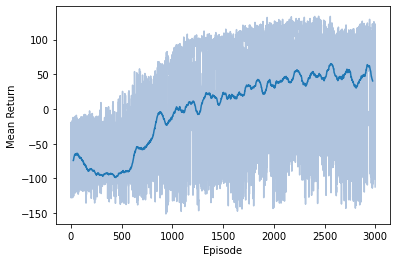

In [ ]:
################################################################################
BELOW IS MY CODE
################################################################################

### Starting the process of training the neural networks

tuned='actor_lr'
value='0_002'

num_its = 5
eps_per_it = 3000
moving_av = 50
num_tests = 100
it_la_test_returns = []
it_ba_test_returns = []
it_returns = []
mean_return = []
moving_av_returns = []


# Train the models
for it in range(num_its):
  algo = TD3('BipedalWalker-v3', actor_lr=0.002)
  trainer = Trainer(
      gpus=num_gpus,
      max_epochs=eps_per_it
  )
  trainer.fit(algo)
  it_returns.append(algo.ep_returns)

  best_actor = algo.best_actor
  last_actor = algo.actor

  env = create_environment('BipedalWalker-v3', max_steps=1600)
  it_la_test_returns.append([])
  it_ba_test_returns.append([])

  # Test each model in the environment under its optimal control policy
  for test in range(num_tests):
    state = env.reset()
    ep_return = 0
    done = False
    while not done:
      action = last_actor(state, epsilon=0)
      next_state, reward, done, info = env.step(action)
      exp = (state, action, reward, done, next_state)
      state = next_state
      ep_return += reward
    it_la_test_returns[it].append(ep_return)
  
  for test in range(num_tests):
    state = env.reset()
    ep_return = 0
    done = False
    while not done:
      action = best_actor(state, epsilon=0)
      next_state, reward, done, info = env.step(action)
      exp = (state, action, reward, done, next_state)
      state = next_state
      ep_return += reward
    it_ba_test_returns[it].append(ep_return)  

  print(f"it:{it}, last actor")
  print(it_la_test_returns[it])
  print(f"it:{it}, best actor")
  print(it_ba_test_returns[it])

  # Store best actor the data in an excel file
for it in range(num_its):
  this_It = pd.DataFrame(it_ba_test_returns[it])
  this_It.columns = ['It ' +  str(it)]
  if it==0:
    results = this_It
  else:
    results = pd.concat([results, this_It], axis=1)

  # Store last actor the data in an excel file
  this_It2 = pd.DataFrame(it_la_test_returns[it])
  this_It2.columns = ['It ' +  str(it)]
  if it==0:
    results2 = this_It2
  else:
    results2 = pd.concat([results2, this_It2], axis=1)
  
# Convert test results into excel files
results.to_csv(f'TD3_' + tuned + '_tuning_ba_value=' + value + '.csv')
results2.to_csv(f'TD3_' + tuned + '_tuning_la_value' + value + '.csv')

# Create mean return list
for ep in range(eps_per_it):
  sum = 0
  for it in range(num_its):
    sum += it_returns[it][ep]
  mean_return.append(sum/num_its)

# Create moving average return list
for i in range(eps_per_it-(moving_av//2)):
  if i > ((moving_av//2)-1):
    lower_lim = i-(moving_av//2)
    upper_lim = i+(moving_av//2)
    moving_av_returns.append(np.sum(mean_return[lower_lim:upper_lim]) / moving_av)

# Plot the graph
x1 = [i for i in range(eps_per_it)]
x2 = [i+(moving_av//2) for i in range(len(moving_av_returns))]

# Plot all results (to show variance)
for it in range(num_its):
  plt.plot(x1, it_returns[it], color='lightsteelblue')
plt.plot(x2, moving_av_returns)
plt.ylabel('Mean Return')
plt.xlabel('Episode')
plt.show()

# Store the data in an excel file
for it in range(num_its):
  this_It = pd.DataFrame(it_returns[it])
  this_It.columns = ['It ' +  str(it)]
  if it==0:
    results = this_It
  else:
    results = pd.concat([results, this_It], axis=1)
results.to_csv('TD3_' + tuned + '_tuning_value=' + value + '.csv')
